## MPIA DS Workshop (June 2024)
# Introduction to ML with Python: Day 2 -- Neural Networks with Pytorch

This Notebook is part of the Workshop we gave at MPIA to introduce machine learning.

**Contributors**: Morgan Fouesneau & Iva Momcheva

The world of data analysis and machine learning is growing rapidly. As a scientist, you may be wondering what deep learning and neural networks are all about. I provide a short introduction to these topics with an emphasis on their potential applications in the field of data analysis and astronomy.

Deep Learning refers to artificial neural networks (ANNs) that use multiple layers of neurons for more complex tasks such as pattern recognition or image classification. Deep Learning models can learn patterns from large amounts of data by adjusting connections between different layers until desired performance is achieved - making them ideal for complex problems such as computer vision or natural language processing (NLP).

Python libraries like TensorFlow, Keras, PyTorch, Theano, Jax, etc., allow scientists to easily create powerful deep learning models without having extensive knowledge on coding algorithms themselves. These libraries enable researchers and developers alike to quickly prototype new ideas using pre-existing architectures while still allowing flexibility when needed for custom implementations. These libraries may be too easy to use for research and development purposes, as often users do not need some understanding to obtain the results of their research leading to sometimes mistakes.

<span style="color:#f66a0a">
‚ö†Ô∏è This notebook requires intermediate Python knowledge, in particular object oriented programming. If you are not familiar with these concepts, you need to review them before proceeding.
</span>

## Setup project environement

First, we define a virtual environment for our project. This is a good practice to avoid conflicts between different projects.
Details on how to create a virtual environment can be found on our FAQ [here](https://mpi-astronomy.github.io/FAQ/chapters/python/virtualenv.html)

Once done, we can activate the environment and install the required packages. We will use the following packages (for both days):

In [ ]:
%%file requirements.txt

matplotlib
pandas
numpy
scikit-learn
torch
astropy
shap
tqdm
ipywidgets
requests

You can install the packages using the following command (after activating your virtual environment):
```bash
python3 -m pip install -q -r requirements.txt
```

For those using Mac M-chips you should be able to use the GPU with Pytorch. 

> Verify that we have MPS support in PyTorch
>
> MPS is a feature of Apple's Metal API that allows to use the M-series' GPUs.

In [ ]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(f"Running on {mps_device} device(s): {x}")
elif torch.cuda.is_available():
    cu_device = torch.device("cuda")
    x = torch.ones(1, device=cu_device)
    print(f"Running on {cu_device} device(s): {x}")
else:
    print ("GPU compatible device not found.")

In [1]:
## Setup notebook

%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
# The following is only for the presentation, you can ignore it
from IPython.display import Markdown
# plt.style.use('fivethirtyeight')
# to keep everything reproducible
np.random.seed(2024)

## Introduction and reminders from Day 1

### What is deep learning?
In its essence, Deep Learning (DL) is one of many techniques collectively known as machine learning. Machine learning (ML) refers to techniques where a computer ‚Äúlearns‚Äù by examples. Machine learning is part of the grand scheme of automated machine decisions. People often refer machine learning as being a form of artificial intelligence (AI). AI is broad and aims at tackling problems the way humans do but to first order designates systems that learn or adapt decision rules. In computer science, a rule-based system is a system that stores and manipulate knowledge to interpret information or take decisions in a useful way. Normally, the term rule-based system only applies to systems involving human-crafted or curated rule sets. For instance in a factory, if an item is not conforming to the size or shape rule, it will be discarded.

![ai_ml_dl](https://mfouesneau.github.io/astro_ds/_images/AI_ML_DL.png)
> The place and role of AI, ML, and Deep Learning in automated machine decisions. Image adapted from Tukijaaliwa, CC BY-SA 4.0, via Wikimedia Commons, [original source](https://en.wikipedia.org/wiki/File:AI-ML-DL.svg)

### Building blocks of neural networks

#### Neurons

A first unit of neural networks is the **neuron**. A neuron takes a set of inputs $(x_1, \ldots, x_n)$, does a weighted sum and apply some simple function to the latter to produce one output. The following is a schematics of a neuron with three inputs.

![neuron](https://mfouesneau.github.io/astro_ds/_images/fcd191316349dd6c2d1856a6eba4fd75a4872f7c34316b43f5e53238795a0fe4.svg)

In this example, the output corresponds to $output=f(w_1 \cdot x_1 + w_2 \cdot x_2 + w_3 \cdot x_3)$. $f$ is called activation function. The activation function is used to turn an unbounded input into an output that has a predictable form.

#### What is a Neural Network Activation Function?
An Activation Function is a function applied on the output of a neuron and decides whether it should be ‚Äúactivated‚Äù. It does not have to output a binary decision. The role of the activation function is to rank the input importance in the process of prediction using simple mathematical operations.

The primary role of the Activation Function is to transform the summed weighted input from the node into an output value fed to the next network layer.

> üí° In deep learning, the Activation Function is often referred to as a Transfer Function in Artificial Neural Network.

The following figure illustrates some of the most common activation functions. These do not have to be bounded to outputs in [0, 1] intervals. Note also that activations functions could be parametric and those parameters adjusted during the training phase similarly to the weights.

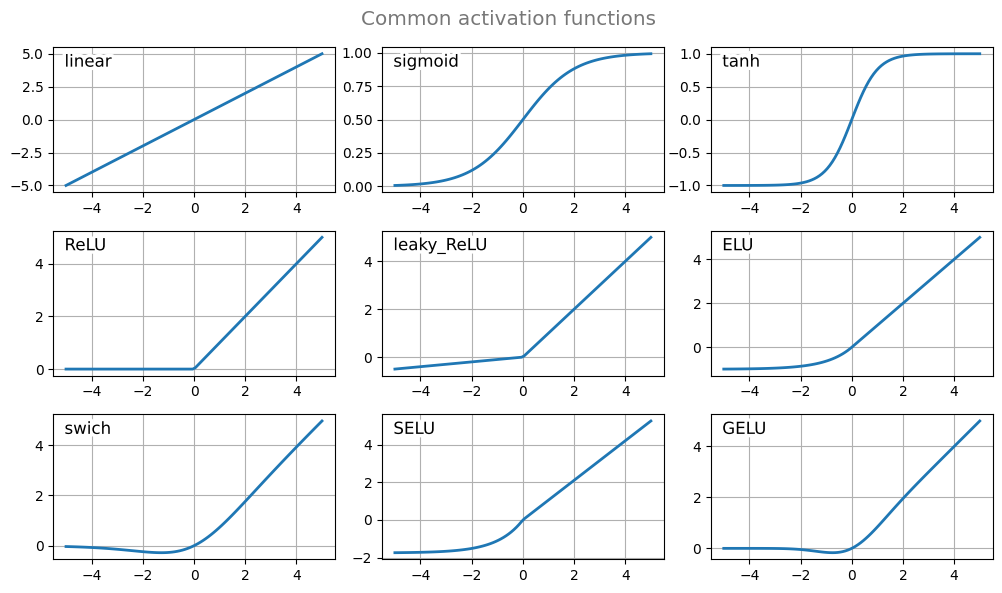

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
import matplotlib.patheffects as pe

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.1):
    return np.maximum(alpha*x, x)

def elu(x, alpha=1.0):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def swich(x):
    return x * sigmoid(x)

def selu(x, alpha = 1.67, scale = 1.05):
    return scale * (np.where(x > 0, x, alpha * (np.exp(x) - 1)))

def gelu(x):
    return 0.5 * x * (1.0 + erf(x / np.sqrt(2.0)))

# Plot the activation functions
x = np.linspace(-5, 5, 100)

labels = ['linear', 'sigmoid','tanh', 'ReLU', 'leaky_ReLU', 'ELU', 'swich', 'SELU', 'GELU']
fns = [linear, sigmoid, tanh, relu, leaky_relu, elu, swich, selu, gelu]

plt.figure(figsize=(10, 6))
for i, (fn, label) in enumerate(zip(fns, labels), 1):
    plt.subplot(3, 3, i)
    plt.plot(x, fn(x), label=label, lw=2)
    plt.text(0.04, 0.9, label,
             transform=plt.gca().transAxes,
             fontsize='larger',
             va='center',
             path_effects = [pe.Stroke(linewidth=5, foreground='w'),
                             pe.Normal()])
    plt.grid(True)

plt.suptitle('Common activation functions', fontsize='x-large', color="#777777")
plt.tight_layout()

#### Simple Example of activation function

Let's assume we have a three-input neuron with a ReLU activation function and the following weights:

$$ w=[0, 1, 4]. $$

What will be the output to an input vector $x = [2, 3, 1]$ and $x^\prime = [1, -3, 0]$?

$$ \begin{aligned}
    y &= f(w \cdot x) \\
    &= f([0, 1, 4] \cdot [2, 3, 1]) \\
    &= f(7) \\
    &= 7
\end{aligned} $$

$$ \begin{aligned}
    y^\prime &= f(w \cdot x^\prime) \\
    &= f([0, 1, 4] \cdot [1, -3, 0]) \\
    &= f(-3) \\
    &= 0
\end{aligned} $$

üîë This process of passing inputs forward to get an output is known as **feedforward**.


‚úçÔ∏è What value do we obtain with a sigmoid function? What about other activation functions?

In [4]:
values = {name: [np.round(fn(7), 3), np.round(fn(-3), 3)] for name, fn in zip(labels, fns)}
values['preact'] = [7, -3]
pd.DataFrame(values, index=['f(7)', 'f(-3)'])

linear  sigmoid   tanh  ReLU  leaky_ReLU   ELU  swich   SELU   GELU  \
f(7)        7    0.999  1.000     7         7.0  7.00  6.994  7.350  7.000   
f(-3)      -3    0.047 -0.995     0        -0.3 -0.95 -0.142 -1.666 -0.004   

       preact  
f(7)        7  
f(-3)      -3

#### How to choose the right Activation Function?

Activation functions could vary within a network. But any choice need to match activation functions to the outputs based on the type of problem to solve.

As a rule of thumb, _ReLU_ is a good activation function to start with in most problems. But it won't always provide the best performance. But the following list gives some guidelines:

* **_ReLU_** activation function should **only be for the hidden layers**.
* **_Sigmoid_** and **_Tanh_** functions are **not for in hidden layers** as they make the model more susceptible to training issues(vanishing gradients).
* **_Swish_** function is recommended in neural **networks with 40 hidden layers and more**.

The following provides some recommendation for the output layer based on the type of prediction problem that you are solving:

* Regression: Linear Activation Functions
* Binary Classification: Sigmoid/Tanh Activation Function
* Multiclass Classification: Softmax
* Multilabel Classification: Sigmoid

The activation function in hidden layers is typically dependent on the type of neural network architecture. As a first try, we will use the following activation function:

* Convolutional Neural Network (CNN): ReLU (or SeLU etc)
* Recurrent Neural Network: Tanh and/or Sigmoid.

> üí° All hidden layers usually use the same activation function. However, the output layer can typically use a different activation function from the hidden layers. The choice depends on the goal or type of prediction made by the model.

#### Example with coding a Neuron

Let's manually implement a neuron using NumPy.

1. first define a ReLU activation function as $f(x) = \max(0, x)$
2. define a class `Neuron` which takes a vector of weights at initialization
3. define the `Neuron.forward` method which takes a vector of inputs and returns the output of the neuron
4. evaluate the code with the previous values.

```python
class Neuron:
  def __init__(self, weights: np.ndarray, activation: Callable):
    pass

  def forward(self, inputs: np.ndarray) -> np.ndarray:
    pass
```

‚úçÔ∏è Code the neuron class

In [6]:
import numpy as np
from typing import Callable

# activation functions defined above

class Neuron:
    def __init__(self, weights: np.ndarray, activation: Callable):
        self.weights = weights
        self.activation = activation
    def forward(self, inputs: np.ndarray) -> float:
        return self.activation(inputs @ self.weights)


weights = np.array([0, 1, 4])
n = Neuron(weights, relu)
print("[2, 3, 1] --> ", n.forward(np.array([2, 3, 1])))
print("[1, -3, 0] --> ", n.forward(np.array([1, -3, 0])))

[2, 3, 1] -->  7
[1, -3, 0] -->  0


### Combining Neurons to create a network

With a single neuron, we can create a scaled weighted sum operator. With a linear activation function, a single neuron corresponds to a linear regression model.

But with many connected neurons we can generate more complex operations.

The following example network has 3 inputs, a single hidden layer with 3 neurons an one output layer with 1 neuron.

A **hidden layer** corresponds to any layer between the input (first) layer and output (last) layer. There can be many hidden layers (deep network)

![network](https://mfouesneau.github.io/astro_ds/_images/440ab20f7db6b184562fcc207637bc1381eebedb56a90b25942cf2a59551881f.svg)

A neural network can have any number of layers with any number of neurons in those layers. The basic idea stays the same: feed the input(s) forward through the neurons in the network to get the output(s) at the end. For simplicity, we‚Äôll keep using the network pictured above for the rest of this post.

We will skip the pen and paper calculations and implement this network in Python.

```python 
class NeuralNetwork:
    
    def __init__(self, 
        input_size: int, 
        hidden_size: int, 
        output_size: int, 
        weights: List[float] = None, 
        activation: Callable = sigmoid):
        pass

    def forward(self, X):
        pass
``` 

```python
model = NeuralNetwork(3, 3, 1, activation=sigmoid)
model.forward([2, 3, 1])
```

> üí° This implementation is freeform. You can use the previous `Neuron` class, make a `Dense` layer or work with arrays of weights.

‚úçÔ∏è Code the NeuralNetwork class

In [9]:
# This implementatation generalizes the number of hidden layers
# reuses the previous activation functions
# However we do not use the Neuron class here
# initializa the weights randomly between -1 and 1 if not provided (classical init)
from typing import List
import numpy as np


class NeuralNetwork:
    def __init__(
        self,
        input_size: int,
        hidden_size: List[int],
        output_size: int,
        weights: List[float] = None,
        activation: Callable = relu,
    ):
        shape = [input_size] + hidden_size + [output_size]
        if weights is None:
            weights = [
                np.random.uniform(-1, 1, (shape_in, shape_out))
                for shape_in, shape_out in zip(shape[:-1], shape[1:])
            ]
        self.weights = weights
        self.activation = activation

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Perform forward propagation"""
        z = X @ self.weights[0]
        for w in self.weights[1:]:
            z = self.activation(z @ w)
        return z

In [11]:
# test the NeuralNetwork class
model = NeuralNetwork(3, [3], 1, activation=sigmoid)
model.forward([2, 3, 1])

array([0.68951905])

The weights are initialized at random and therefore without imposing the weights and doing the calculations by hand, it will be difficult to verify the model. Let's train our model instead.

### Training a Neural Network

Let's use the common `iris` dataset, a multivariate data set used and made famous by the British statistician and biologist Ronald Fisher in his 1936 paper.

The data set consists of $50$ samples from each of three species of Iris (setosa, virginica, and versicolor) and four measurements from each sample: the length and the width of the sepals and petals, in centimeters.

In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Using this dataset, let's create a neural network model to predict the species given the measurements.

‚úçÔ∏è define the model variable and call `.forward()` on the model with the first row of the dataset.

In [20]:
X = iris['data']
y = iris['target']

model = NeuralNetwork(X.shape[-1], [3], 1, activation=sigmoid)
model.forward(X[0])

array([0.13442011])

#### The Loss function, objective function

Before we train our network, we first need to define a performance metric which the training procedure will optimize.

For simplicity here, we will use the Mean Squared Error (MSE) as the loss function:

$$ MSE = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2, $$

where $N$ is the number of samples, $y_i$ is the true label, and $\hat{y}_i$ the output prediction of the network.
The better our predictions, the lower MSE value, i.e. lower loss.

> üí° The training procedure minimizes the loss function given a training set

‚úçÔ∏è define the loss function

In [21]:
def mse(y_true: np.array, y_pred: np.array) -> float:
    return np.mean((y_true - y_pred) ** 2)

In [23]:
yhat = np.array([model.forward(xk) for xk in X])
print("MSE loss (t=0) = ", mse(y, yhat))

MSE loss (t=0) =  1.559513317276856


Now we have to optimize this function, i.e. the loss of the neural network. We can adjust the network‚Äôs weights to change the predictions.

#### Optimization and backpropagation

> ‚ö†Ô∏è This part is a bit mathematical. 


The loss function $L$ is function of all the weights $W$ and we want to minimize $L$ w.r.t $W$.

Let's look at optimizing a single weight $w_{11}$ corresponding to the connection of the $x_{1}$ with the first neuron in the hidden layer $h_1$. The derivative of $L$ w.r.t. $w_{11}$ is 

$$\begin{align}
\frac{\partial L}{\partial w_{11}} &= \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_{11}} \\
\frac{\partial L}{\partial \hat{y}} &= -2 (y - \hat{y})
\end{align}$$

The other term is a bit more complicated. But since $w_{11}$ is between $x_1$ and $h_1$:

$$\begin{align}
\frac{\partial \hat{y}}{\partial w_{11}} &= \frac{\partial \hat{y}}{\partial h_1} \cdot \frac{\partial h_1}{\partial w_{11}} \\
\frac{\partial \hat{y}}{\partial h_1} &= w_{21} \cdot f^\prime(w_{21} h_1 + w_{22} h_2 + w_{23} h_3)\\
\frac{\partial h_1}{\partial w_{11}} &= x_1 \cdot f^\prime(w_{11} x_1 + w_{12} x_2 + w_{13} x_3)
\end{align}$$

Finally, most activation functions $f$ have relatively simple derivative $f^\prime$. For instance, the sigmoid function has a simple derivative 

$$\begin{align}
f(x) &= \frac{1}{1 + e^{-x}} \\
f^\prime(x) &= \frac{e^{-x}}{(1 + e^{-x})^2} = f(x) \cdot (1 - f(x))
\end{align}$$

We managed to express all the necessary terms in the derivative of $L$ w.r.t. $w_{11}$:

$$\begin{align}
\frac{\partial L}{\partial w_{11}} &= \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial h_{1}} \cdot \frac{\partial {h_1}}{\partial w_{11}}
\end{align}$$

This system of calculating partial derivatives by working backwards is known as **backpropagation**. Backpropagation is the process of finding the derivative of the loss function w.r.t. all the weights $W$.

#### Training through Stochastic Gradient Descent

The final step of our model is to minimize the loss function w.r.t. all the weights using our training data.

A traditional approach uses an optimization algorithm essentially based on stochastic gradient descent (SGD).
It is a variant of Gradient Descent (GD) but it uses only a random subset of the training data (also known as a mini-batch) rather than the entire training data set to calculate the gradient of the loss function. This random selection of data provides faster and more frequent updates to the model parameters, making it more efficient than GD when the data set is large. SGD repeats this process for a fixed number of iterations or until the convergence of the loss function. 

The learning rate $\eta$ is an hyperparameter that controls the step size at each iteration, e.g.:

$$ w_1 \leftarrow w_{11} - \eta \frac{\partial L}{\partial w_{11}} $$

If we do this for every weight in the network, the loss will slowly decrease and our network will improve.

The SGD training process will look like this:
1. Choose one random sample/subset from our dataset. 
2. Calculate all the partial derivatives of loss with respect to weights
3. Update the weights by subtracting the learning rate times the partial derivatives.
and repeat until convergence.

To avoid having to code everything in the following we use `sklearn.neural_network.MLPClassifier` which implements an SGD optimizer (as well as others).

‚úçÔ∏è call the MLPClassifier with the iris dataset and fit the model. Use the `solver='sgd'` and set the learning rate `alpha`, `hidden_layer_sizes`.

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error as mse

model = MLPClassifier(hidden_layer_sizes=(3,3), solver='sgd', max_iter=10_000, random_state=1, alpha=1e-5)

model.fit(X, y)
yhat = model.predict(X)
print("Final loss: ", mse(y, yhat))

Final loss:  0.02


We can also visualize the loss values as function of the training iterations, aka **epoch**.

Text(0, 0.5, 'Loss (MSE)')

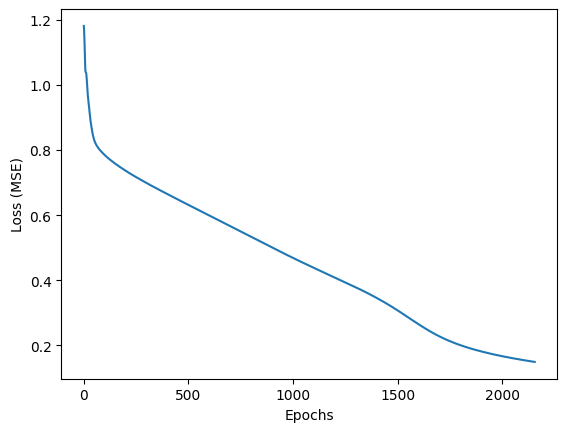

In [27]:
plt.plot(model.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

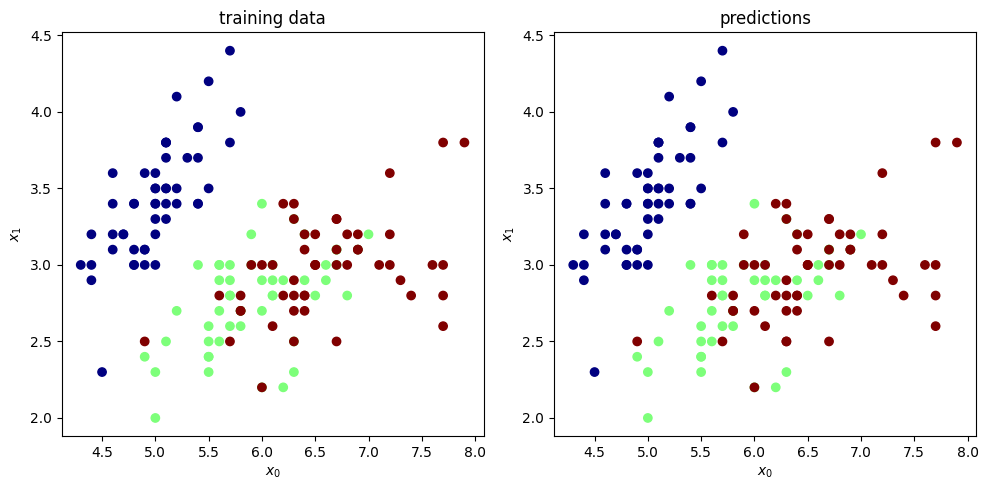

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('training data')
plt.subplot(1, 2, 2)
yhat = model.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=yhat, cmap='jet')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('predictions')
plt.tight_layout()

> ‚ö†Ô∏è The above example is also an example of bad practice. We should use a validation set to monitor the performance of the model and avoid overfitting.

### Why are deep neural networks hard to train?

Training NNs may sometimes lead to catastrophic failures (e.g., wrong activation function, forgetting to normalize the input data). There are two major challenges you might encounter when training your deep networks.

#### Vanishing Gradients

Like the sigmoid function, certain activation functions compress an infinite interval into [0, 1]. Hence, their derivative becomes small. For shallow networks with only a few layers that use these activations, this isn‚Äôt a big problem. But, when networks contain more layers, the product of those gradients becomes too small for training to work effectively.

#### Exploding Gradients

Exploding gradients occurs when significant error gradients accumulate and result in very large updates to neural network model weights during training with SGD based optimizers. With these exploding gradients, you can obtain unstable networks and the learning cannot be completed.

The values of the weights can also become so large as to overflow.

###  Key vocabulary

* **Artificial Neural Network** (ANN): A computational system inspired by the way biological neural networks in the human brain process information.
* **Neuron**: A building block of ANN. It is responsible for accepting input data, performing calculations, and producing output.
* **Deep Neural Network**: An ANN with many layers placed between the input layer and the output layer.
* **Input data**: Information or data provided to the neurons.
* **Weights**: The strength of the connection between two neurons. Weights determine what impact the input will have on the output.
* **Bias**: An additional parameter used along with the sum of the product of weights and inputs to produce an output.
* **Activation Function**: Determines the output of a neural network.
* **Feed forward** (forward propagation): The process of feeding the input data to the neurons.
* **Back propagation** (back propagation): The process of adjusting the weights and biases of the neurons through the gradient of the loss function.
```

### Advantages & Disadvantages of Neural Networks

#### Advantages 
* Fault tolerance: even if a few neurons are not "working" properly, that would not prevent the neural networks from generating outputs.

* Real-time Operations: neural networks can learn synchronously and easily adapt to their changing environments.

* Adaptive Learning: neural networks can learn how to work on different tasks, or sub-tasks with proper training.

* Parallel processing capacity: neural networks can perform multiple tasks simultaneously.

#### Disadvantages

* Unexplained behavior of the network: neural networks provide a solution to a problem but rarely a why and how it made the decisions it made. Understanding the behavior of a model represents additional tasks to the architect (i.e., the user).

* Determination of appropriate network structure: there is no generic rule (or rule of thumb) to design a neural network architecture. A proper network structure is achieved by trying the best network, in a trial and error approach. It is a process that involves refinement.

* Hardware dependence: To be efficient in computational speed (training or evaluation), neural networks require (or are highly dependent on) processors (CPU, GPU, TPU) with adequate processing capacity.

### What sort of problems can Deep Learning not solve?

DL is not always capable to solve problems. It will not work in
* any case where only a small amount of training data is available,
* tasks requiring an explanation of how the answer was arrived at (interpretability not guaranteed),
* Classifying things which are nothing like their training data (not good at genaralization).

### What sort of problems can Deep Learning solve but should not be used for?

Deep Learning needs a lot of computational power, it often relies on specialised hardware like graphical processing units (GPUs). Many computational problems can be solved using less intensive techniques, but could still technically be solved with Deep Learning.
It is tempting to use the fashion techniques to solve old problems, but we should remain critical.

Deep learning can technically solve the following but it would probably be a wasteful way to do it:

* Logic operations, such as sums, averages, ranges etc. 
* Modelling well defined systems, where the equations governing them are known and understood.
* Basic computer vision tasks such as edge detection, decreasing colour depth or blurring an image.

## Deep Learning Libraries in Python

There are many software libraries available for Deep Learning. Python includes:

### PyTorch
[PyTorch](https://pytorch.org/) was developed by Facebook in 2016 and it is a popular choice for Deep Learning applications. It was developed for Python from the start and feels a lot more ‚Äúpythonic‚Äù than TensorFlow. Like TensorFlow it was designed to do more than just Deep Learning and offers some very low level interfaces. PyTorch Lightning offers a higher level interface to PyTorch to set up experiments. Like TensorFlow it is also very easy to integrate PyTorch with a GPU. 

### Jax + Flax

[Jax](https://jax.readthedocs.io/) is a Python library developed by Google for high-performance numerical computing and machine learning. It provides an interface that is similar to NumPy but that can run on GPUs and TPUs transparently for the users offering significantly improved performance. JAX includes automatic differentiation, which makes it easy to train machine learning models using techniques like stochastic gradient descent. 

[Equinox](https://docs.kidger.site/equinox/) is a neural network library that is built on top of JAX (alternative to flax) with easy-to-use PyTorch-like syntax. It provides at most wrappers around JAX, which makes it more flexible than other libraries.

[Flax](https://flax.readthedocs.io/) is a neural network library that is built on top of JAX and is designed for flexibility. It provides a high-level API for defining and training neural networks and has built-in support for advanced training techniques like mixed precision and gradient checkpointing. 

### Keras
[Keras](https://keras.io/) is designed to be easy to use and usually requires fewer lines of code than other libraries. We have chosen it for this workshop for that reason. Keras can actually work on top of TensorFlow (and several other libraries), hiding away the complexities of TensorFlow while still allowing you to make use of their features.

The performance of Keras is sometimes not as good as other libraries and if you are going to move on to create very large networks using very large datasets then you might want to consider one of the other libraries. But for many applications the performance difference will not be enough to worry about and the time you will save with simpler code will exceed what you will save by having the code run a little faster.

### TensorFlow
[TensorFlow](https://www.tensorflow.org/) was developed by Google and is one of the older Deep Learning libraries, ported across many languages since it was first released to the public in 2015. It is very versatile and capable of much more than Deep Learning but as a result it often takes a lot more lines of code to write Deep Learning operations in TensorFlow than in other libraries. It offers (almost) seamless integration with GPU accelerators and Google‚Äôs own TPU (Tensor Processing Unit) chips that are built specially for machine learning.

> ‚ö†Ô∏è Tensorflow is about to be deprecated by Google (not further dev.) in favor of JAX.

### Which library should I use/learn?

There are no standard answer to which library should I use or learn, even when having a specific problem.

TensorFlow and PyTorch are currently the most widely used deep learning libraries, while JAX is growing in popularity due to its efficient GPU and TPU acceleration, automatic differentiation, and high flexibility. 

It is important to note that Google currently slows down the development of Tensorflow in favor of JAX. But Tensorflow remains important for insdustry applications. It provides many services and pre-trained models.

Jax is the new kid in the playground. Its development is extremely fast, and it gets a lot of traction in the scientific community. (A few developpers are former-astronomers.)

## Exercise: Logical XOR network

In this exercise, you will implement a simple XOR network, i.e. implement a network that exactly matches the behavior of a simple logical XOR operator.

For this exercise, the network needs at least one hidden layer to solve the problem.

### Logical XOR 

XOR stands for "exclusive or". The output of the XOR function has only a true value if the two inputs are different. If the two inputs are identical, the XOR function returns a false value. The following table shows the inputs and outputs of the XOR function.

In [29]:
# x1, x2, y
xor_data = np.array([[0, 0, 0],
                     [1, 0, 1],
                     [0, 1, 1],
                     [1, 1, 0]])
or_data = np.array([[0, 0, 0],
                    [1, 0, 1],
                    [0, 1, 1],
                    [1, 1, 1]])
and_data = np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0, 1, 0],
                     [1, 1, 1]])

The following figure illustrates the logical operations OR, AND, and XOR. 
In contrast to OR and AND problems, the XOR one cannot be linearly separated by a single boundaryline. To solve this problem, we will need two boundary lines, hence requires at least one hidden layer in our neural network.

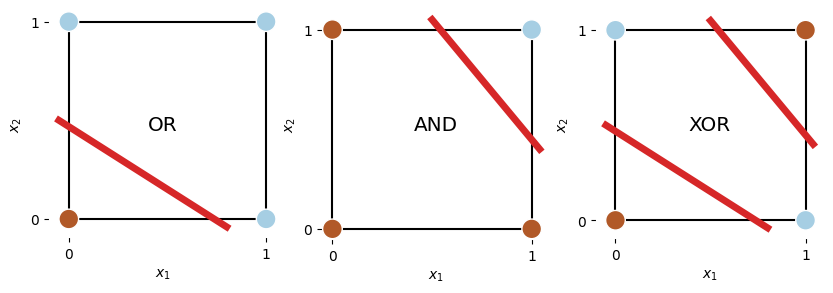

In [30]:
def plot_data(xor_data, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='k')
    ax.scatter(xor_data[:, 0], xor_data[:, 1], c=xor_data[:, 2],
               cmap='Paired_r', s=200, zorder=10, edgecolors='w')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    plt.setp(ax.spines.values(), color='w')
    ax.set_xticks([0, 1], [0, 1])
    ax.set_yticks([0, 1], [0, 1])

plt.figure(figsize=(10, 4))
ax = plt.subplot(131, aspect='equal')
plot_data(or_data, ax)
plt.plot([-0.05, 0.8], [0.5, -0.04], color='C3', linestyle='-', lw=5)
plt.text(0.5, 0.5, "OR", ha='center', va='center', transform=ax.transAxes, fontsize='x-large')
ax = plt.subplot(132, aspect='equal')
plot_data(and_data, ax)
plt.plot([0.5, 1.04], [1.05, 0.4], color='C3', linestyle='-', lw=5)
plt.text(0.5, 0.5, "AND", ha='center', va='center', transform=ax.transAxes, fontsize='x-large')
ax = plt.subplot(133, aspect='equal')
plot_data(xor_data, ax)
plt.plot([-0.05, 0.8], [0.5, -0.04], color='C3', linestyle='-', lw=5)
plt.plot([0.5, 1.04], [1.05, 0.4], color='C3', linestyle='-', lw=5)
plt.text(0.5, 0.5, "XOR", ha='center', va='center', transform=ax.transAxes, fontsize='x-large');

The next step is to define a Neural Network that is able to solve the XOR problem. 
With the correct choice of functions and weight parameters, a Neural Network with one hidden layer is able to solve the XOR problem.
Because we have logical operations, a threshold activation function should be sufficient.

![xor](https://mfouesneau.github.io/astro_ds/_images/6f4674816e1e53d870846fd43586f325dbc19d93506e6253302a52f631a6dc88.svg)

Use 
```python
from sklearn.neural_network import MLPClassifier
```

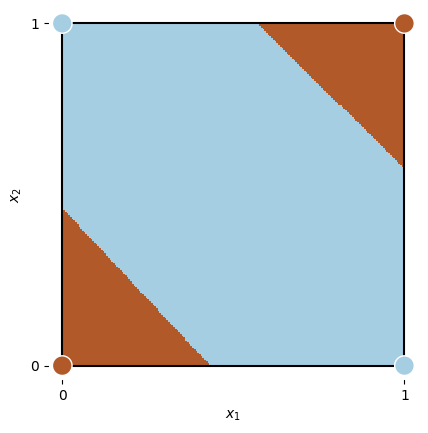

In [31]:
from sklearn.neural_network import MLPClassifier
import numpy as np

np.random.seed(0)

model = MLPClassifier(
                activation='logistic',
                max_iter=20_000,
                hidden_layer_sizes=(2,),
                solver='lbfgs',
                )

X = xor_data[:, :2]
y = xor_data[:, 2]
model.fit(X, y)

X_, Y_ = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
Z = model.predict(np.c_[X_.ravel(), Y_.ravel()])

ax = plt.subplot(111, aspect='equal')
plot_data(xor_data, ax)
Z = Z.reshape(X_.shape)
plt.pcolormesh(X_, Y_, Z, cmap=plt.cm.Paired_r)
plt.xlim(-0.04, 1.04)
plt.ylim(-0.04, 1.04);

## Non-linear regression with Pytorch

In this tutorial, we will explore coding neural networks to do a non-linear regression with a multi-layer perceptron.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

### Generate mock data

In this exercise, we generate 100 pairs of values from a non-linear function 

$$f(x) = x^3 - x^2 + 25 \cdot \sin(2x),$$

and we add noise to a random uniform sample:

$$ y = \mathcal{N}(f(x), 10)$$

‚úçÔ∏è Implement the function `f(x)` and generate a 100 data points (x, y) with noise. Plot your data to make sure it looks ok.

Text(0, 0.5, 'y')

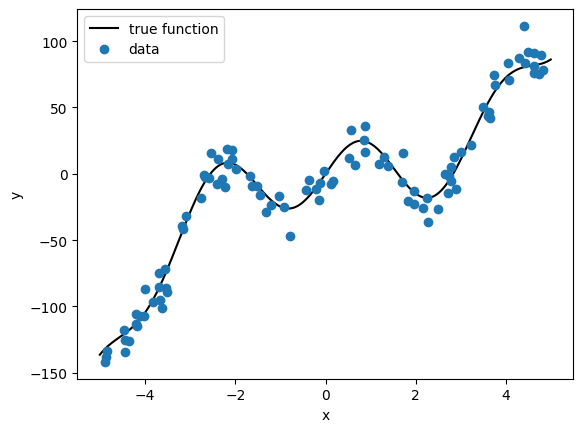

In [34]:
def ftrue(x):
    return x ** 3 - x ** 2 + 25 * np.sin(2 * x)

xtrue = np.arange(-5, 5, 0.01)
ytrue = ftrue(xtrue)

n = 100
x = np.random.uniform(-5, 5, n)
y = ftrue(x) + np.random.normal(0, 10, n)

plt.plot(xtrue, ytrue, label='true function', color='k')
plt.plot(x, y, 'o', label='data', color='C0')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

### MLP in PyTorch

In this section, we code a simple network using PyTorch `torch.nn` library.

To define a model, PyTorch requires a class definition deriving `nn.Module`. This class pre-defines neural networks properties and important methods.

Below, we define our neural network class. The main aspects are

1.  the **initialization**/**constructor** function `__init__`, which defines the properties of our model and parameters
2.  the **`forward`** method which takes the model's input and computes the corresponding prediction given the current model. 

PyTorch allows flexibility in how to define neural network modules, we show below a concise implementation. Regardless, any implementation should work the same way eventually.

```python

class  MLP(nn.Module):
    def __init__(self, layout: Sequence[int]):
        ...
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ...
```

In [37]:
# number of nodes per layer (input, ..., output)
layout = [1, 10, 10, 10, 1]

Typically, our network need to take `x`, apply a series of `Linear` layer followed by an activation function until the last output layer. This corresponds to a feed foward function looking something like

```python
z = nn.Linear(1, 10)(x)
z = nn.Linear(10, 10)(z)
z = nn.ReLU()(z)
z = nn.Linear(10, 10)(z)
z = nn.ReLU()(z)
z = nn.Linear(10, 1)(z)
```

All together, a common implementation would be the following:

‚úçÔ∏è Implement an MLP module using PyTorch.

if you want to use a list of layers (aka pipeline in sklearn) you can use `nn.Sequential`

In [38]:
from typing import Sequence
import torch
from torch import nn

class MLP(nn.Module):
    ''' Multi-layer perceptron for non-linear regression. '''
    def __init__(self, layout: Sequence[int]):
        super().__init__()  # initialize following nn.Module
        n_inputs = layout[0]
        n_outputs = layout[-1]
        n_hidden = layout[1:-1]

        self.sequence = nn.Sequential()
        self.sequence.add_module("input", nn.Linear(n_inputs, n_hidden[0]))
        self.sequence.add_module("input_activation", nn.ReLU())
        for e, (n1, n2) in enumerate(zip(n_hidden[:-1], n_hidden[1:])):
            self.sequence.add_module(f"hidden_{e:d}", nn.Linear(n1, n2))
            self.sequence.add_module(f"hidden_activation_{e:d}", nn.ReLU())

        self.sequence.add_module("output", nn.Linear(n_hidden[-1], n_outputs))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequence(x)

model = MLP(layout)
model

MLP(
  (sequence): Sequential(
    (input): Linear(in_features=1, out_features=10, bias=True)
    (input_activation): ReLU()
    (hidden_0): Linear(in_features=10, out_features=10, bias=True)
    (hidden_activation_0): ReLU()
    (hidden_1): Linear(in_features=10, out_features=10, bias=True)
    (hidden_activation_1): ReLU()
    (output): Linear(in_features=10, out_features=1, bias=True)
  )
)

We can access the current parameter values of this model instance like so:

In [39]:
p = list(model.parameters())
p

[Parameter containing:
 tensor([[ 0.0713],
         [-0.5441],
         [ 0.9039],
         [-0.4040],
         [ 0.6096],
         [-0.8009],
         [-0.6808],
         [-0.6066],
         [ 0.2366],
         [ 0.1081]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3143, -0.6128, -0.6236,  0.9086, -0.5793, -0.2118,  0.4339, -0.4143,
         -0.3808,  0.9516], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1320, -0.0512,  0.0685, -0.2579,  0.1537, -0.0879, -0.0986,  0.1797,
           0.2006, -0.2756],
         [ 0.2581, -0.1226,  0.0653,  0.0457, -0.0859,  0.2887, -0.0745, -0.1336,
          -0.1388,  0.0205],
         [ 0.1570,  0.0350, -0.2879,  0.1990, -0.1877, -0.1095,  0.0191, -0.1804,
          -0.1005, -0.2696],
         [ 0.1496,  0.2642, -0.1567,  0.1325, -0.2178,  0.0600, -0.0260, -0.1001,
           0.0778,  0.2228],
         [-0.0984, -0.2227,  0.1525, -0.1417, -0.0235, -0.2040, -0.1679,  0.1354,
           0.2795,  0.0060],
         [-0.0676,  0.03

**Exercise**

1. What are these parameters? (Hint: they are in oder of the sequence and computations in the forward method.)

2. Guess how the weights are initialized.

### Preparing our training data, `Dataset`

In PyTorch, there are multiple ways to prepare a dataset for the model training. 
The main aspect is to convert the data into tensors which are transparently moved to GPUs if needed.

To make a standard API that works with small and large datasets, PyTorch provides two data primitives: 
* `torch.utils.data.Dataset` to store the data in a reusable format,
* `torch.utils.data.DataLoader` takes a `Dataset` object as input and returns an iterable to enable easy access to the training data (especially useful for batch training).

#### `Dataset`

To define a `Dataset` object, we have to write a class deriving the latter and specify two key methods:

1.  `__len__`, which tells subsequent applications how many data points there are in total (useful if you load the data by chunk); and
2.  the `__getitem__` function, which takes an index as input and outputs a corresponding (input, output) pair.

In [41]:
from torch.utils.data import Dataset
class Data(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''
    def __init__(self, X: np.array, Y: np.array, device=None):
        self.X = torch.from_numpy(X.astype('float32'))
        # self.X = torch.reshape(torch.from_numpy(X.astype('float32')), (len(X), 1))
        self.Y = torch.from_numpy(Y.astype('float32'))
        # self.Y = torch.reshape(torch.from_numpy(Y.astype('float32')), (len(Y), 1))

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.Y[idx])

# instantiate Dataset object for current training data
d = Data(x, y)
d

In [42]:
d.X

tensor([-0.3642, -2.2237,  0.8678,  3.6386, -3.8247,  0.1738, -3.6793,  2.1686,
        -1.0394,  0.6542, -3.1672, -3.5515, -0.1194, -1.4439,  4.4043,  2.6533,
         2.4866,  4.0372, -4.1658,  0.5219,  0.8448,  4.6194, -2.0785, -2.5917,
        -3.9971, -4.8357,  4.2953,  1.6992,  2.8515, -2.1827,  0.8641, -4.3604,
        -0.1437,  4.7750,  3.7651, -1.6184,  4.6157, -2.6830,  4.4932,  4.4138,
         2.9920,  1.3045,  3.7429, -2.0698,  3.4894,  1.1788, -4.8676, -1.5277,
        -3.5186,  4.8183, -0.2163, -0.0261,  1.3947, -1.3142, -3.6310,  3.2212,
        -3.1015,  0.1132, -2.7568, -4.0216,  3.6219,  4.7292,  4.6083,  4.0656,
         2.7405, -1.6685, -4.1890, -0.9276, -2.6777, -3.6751, -4.4657,  2.2559,
        -4.8857,  2.7058, -3.5305, -4.2048, -4.1040,  1.7205, -2.5463, -0.7946,
         0.5737,  3.6055,  2.2704, -2.2967, -3.6852, -4.4463, -1.9840, -2.3788,
        -0.4386,  1.8328,  1.9563, -2.1648, -1.2007, -3.1885,  2.8855, -4.4315,
         1.9700,  2.7870,  2.7741, -2.40

#### `DataLoader`

Let's instanciate also the data loader (or data feeder). For this example, we will provide the data in batches of 25 random examples (out of 100).

In [44]:
from torch.utils.data import DataLoader
# instantiate DataLoader
traindata = DataLoader(d, batch_size=25 , shuffle=True)
traindata

`traindata` is an iterator:



In [45]:
for i, data in enumerate(traindata, 0):
    x_, y_ = data
    print(i, "x: ", x_, "\n  y:", y_)

0 x:  tensor([ 4.8183,  1.3947,  2.6533,  4.6194,  3.7651,  2.7405, -3.1015, -4.8357,
        -0.2163, -1.0394, -1.6184,  2.9920, -3.5515, -4.1658, -3.6751,  0.1132,
         3.6219,  4.6157,  1.3045,  2.8855,  1.8328, -2.7568, -0.7946,  0.1738,
         3.6386]) 
  y: tensor([  78.4327,    5.5303,   -0.4901,   90.9112,   67.1371,   -1.9852,
         -31.6549, -133.5777,  -11.7133,  -17.0724,   -9.3379,   16.6588,
         -72.0295, -114.6695,  -95.4372,   -7.9374,   46.8029,   81.3188,
          12.6270,  -11.3457,  -20.3207,  -18.3527,  -47.1371,   -5.4212,
          41.8810])
1 x:  tensor([-4.3604, -0.9276,  2.7741, -4.1890,  2.2559, -1.3142, -2.6830,  1.6992,
         4.6083,  3.2212, -2.2967, -4.2048, -2.4058,  0.5219, -3.6793,  4.7750,
        -1.2007,  0.8448,  2.8515, -1.9840,  0.5737, -2.1827, -3.1672, -3.5305,
        -3.1885]) 
  y: tensor([-125.8250,  -24.6541,   -5.0671, -112.8856,  -18.1650,  -28.5785,
          -0.9932,   -6.4028,   76.0592,   21.8297,   -3.5886, -105.59

> üí° The training set in our current example is small and training by batch is not necessary

### Training the model

In many libraries, writing the training code is the most important part and varies from library to library.
They also have common bricks:
* the _loss function_: let's take MSE here.
* the _optimizer_: let's take _Adam_ (a flavor of stochastic gradient descent) with a learning rate $10^{-4}$
* the _training loop_: which for many epoch, feed the data to the model, calculate the loss function, the gradient of it (backpropagation), and update the optimizer for the next iteration. 

In PyTorch, this looks like the following:

In [48]:
from tqdm.auto import tqdm

loss_function = nn.MSELoss()
layout = [1, 10, 10, 10, 1]
model = MLP(layout)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 20_000

logs = []  # keep track

# the following loop could be
# for epoch in range(0, epochs), but we'll use tqdm to provide a progress indicator
with tqdm(range(0, epochs), total=epochs) as pbar:
    for epoch in pbar:
        current_loss = 0.0
        # Iterate over the batches from the DataLoader
        for i, batch in enumerate(traindata):
            # Get inputs
            x_, y_ = batch
            # reset/Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            # ypred = model(x_).squeeze()
            x_2d = torch.reshape(x_, (len(x_), 1))
            ypred = model(x_2d).squeeze()
            # Compute loss
            loss = loss_function(ypred, y_)
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Print statistics
            current_loss += loss.item()
        # display some progress ;)
        #if (epoch + 1) % 2500 == 0:
        #    print(f'Loss after epoch {epoch+1:5d}: {current_loss:.4g}')
        pbar.set_postfix({"loss": float(current_loss)})
        logs.append(current_loss)
        current_loss = 0.0

# Process is complete.
print('Training finished.')

  0%|          | 0/20000 [00:00<?, ?it/s]

Training finished.


Text(0, 0.5, 'MSE')

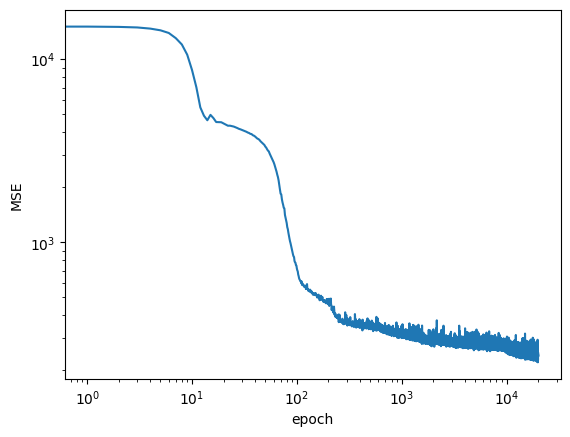

In [49]:
plt.loglog(logs)
plt.xlabel('epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'y')

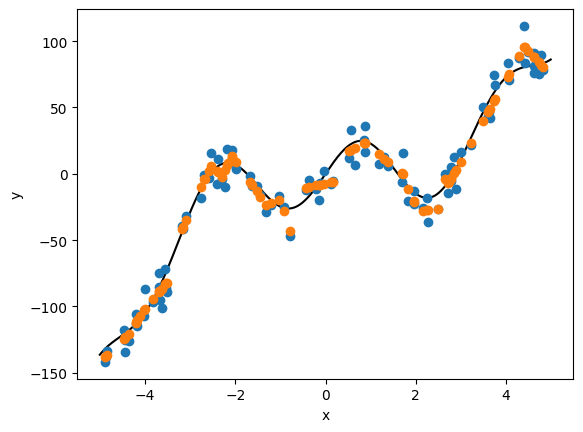

In [50]:
# let's check our predictions
x_ = torch.from_numpy(x.astype('float32'))
ypred = model(torch.reshape(x_, (len(x_), 1))).squeeze().cpu().detach().numpy()

plt.plot(xtrue, ytrue, color='k')
plt.plot(x, y, 'o', color='C0')
plt.plot(x, ypred, 'o', color='C1')
plt.xlabel('x')
plt.ylabel('y')

### Tuning Optimizers and learning curves

Because Adam is very popular and it is a good choice for training neural networks, we focus on building understanding of tuning its parameters: learning rate, exponential decay rate for the momentum term, and learning rate decay.

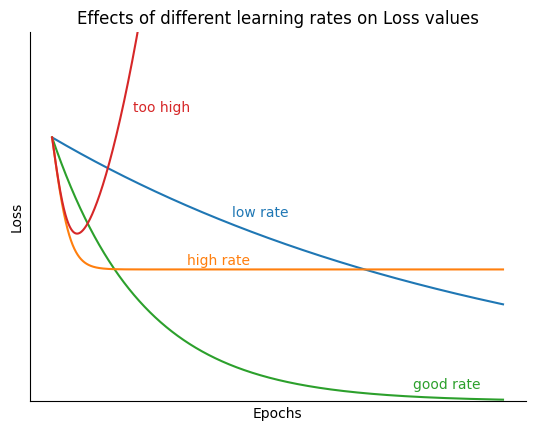

In [51]:
epochs = np.arange(10_000)

eta = 5e-4
plt.plot(epochs, np.exp(- epochs * eta), label='good', color='C2')
plt.text(8000, 0.05, 'good rate', color='C2')
eta = 1e-4
plt.plot(epochs, np.clip(np.exp(- epochs * eta), 1e-1, 10), label='low', color='C0')
plt.text(4000, 0.7, 'low rate', color='C0')
eta = 5e-3
plt.plot(epochs, 1.5 - 1 / (1 + np.exp(- epochs * eta)), label='high', color='C1')
plt.text(3000, 0.52, 'high rate', color='C1')
plt.plot(epochs, (1.5 - 1 / (1 + np.exp(- epochs * eta))) + (eta * epochs / 10) ** 2, label='high', color='C3')
plt.text(1800, 1.1, 'too high', color='C3')
plt.ylim(0, 1.4)
ax = plt.gca()
plt.setp(ax.get_xticklabels() + ax.get_yticklabels() + ax.get_xticklines() + ax.get_yticklines(),
         visible=False)
plt.setp([ax.spines['top'], ax.spines['right']], visible=False)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Effects of different learning rates on Loss values');

A small learning rate corresponds to updates and therefore a slower model training. i.e. it would require many updates to the parameters to reach the point of minima. On the other hand, a large learning rate would mean large steps to the parameters thus often tends to divergence instead of convergence.

An optimal learning rate value (default value $0.001$ for Adam) means that the optimizer would update the parameters just right to reach the local minima in a given number of epochs. Varying learning rate between $0.0001$ and $0.01$ is the typical range in most cases, but this depends on the actual optimizer.

### momentum decay $(\beta_1, \beta_2)$
 
$\beta_1$ is the exponential decay rate for the momentum term. It‚Äôs default value in PyTorch is $0.9$ (from the original paper). 

$\beta_2$ is the exponential decay rate for velocity term. The default value is 0.999 in the PyTorch implementation. This value should be set as close to 1.0 as possible to help with sparse gradient.

### Learning Rate Decay
 
Learning rate decay decreases as the parameter values reach closer to the global optimal solution. This avoids overshooting the minima often resulting in faster convergence of the loss function. The PyTorch implementation refers to this as `weight_decay` with default value being zero.

### Epsilon
 
Although not a tuning hyperparameter, it is a very tiny number to avoid any division by zero error in the implementation. The default value is $10^{-8}$.


**Exercise** Explore the model's behavior

1. Make sure you understand the various lines of code.
2. Change the model layout, activations, optimizer, etc.
3. Change the mini-batch configuration. e.g. All data at once

Run the model when you change something and discuss notable differences. Explain what your observations. (If you do not see anything, that could happen. Explain why)

## Revisiting the XOR problem with pytorch.

In [57]:
# create data
X = torch.Tensor([[0., 0.],
                  [0., 1.],
                  [1., 0.],
                  [1., 1.]])

y = torch.Tensor([0., 1., 1., 0.]).reshape(X.shape[0], 1)

‚úçÔ∏è  train an XOR network with PyTorch: make the XOR class and train it on xor data.

In [58]:
class XOR(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2,2)
        self.activation = nn.Sigmoid()
        self.linear2 = nn.Linear(2,1)

    def forward(self, input):
        z = self.linear(input)
        sig = self.activation(z)
        return self.linear2(sig)

# instantiate the model
xor_network = XOR()
# define the loss function
mseloss = nn.MSELoss()
# define the optimizer
optimizer = torch.optim.Adam(xor_network.parameters(), lr=0.03)
# number of epochs (e.g. 1000)
epochs = 1_000
# keep track of the loss values
logs = []

# train the model: training loop
# this one is different as we do not need a batch loading mechanism we can use the arrays directly.
with tqdm(range(epochs), total=epochs) as pbar:
    for epoch in pbar:
        # reset the gradients
        optimizer.zero_grad()
        # forward pass
        ypred = xor_network(X)
        # compute the loss
        loss = mseloss(ypred, y)
        # backward pass
        loss.backward()
        # optimization
        optimizer.step()
        # keep track of the loss
        logs.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'MSE')

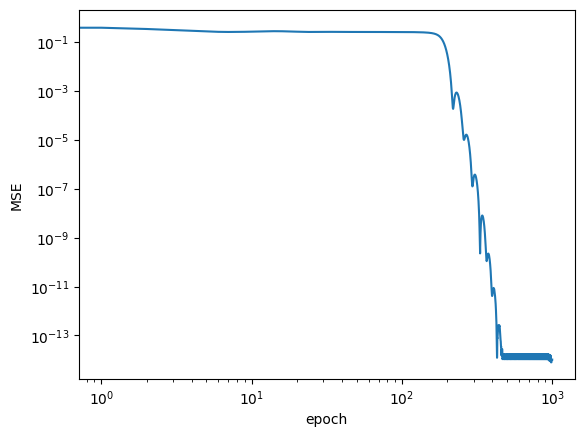

In [59]:
plt.loglog(logs)
plt.xlabel('epoch')
plt.ylabel('MSE')

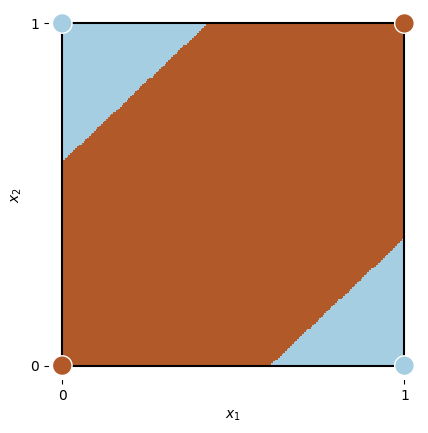

In [60]:
X_, Y_ = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
x1 = torch.from_numpy(np.c_[X_.ravel().astype('float32'), Y_.ravel().astype('float32')])
Z = np.round(xor_network(x1).squeeze().cpu().detach().numpy())

xor_data = np.array([[0, 0, 0],
                     [1, 0, 1],
                     [0, 1, 1],
                     [1, 1, 0]])

ax = plt.subplot(111, aspect='equal')
plot_data(xor_data, ax)
Z = Z.reshape(X_.shape)
plt.pcolormesh(X_, Y_, Z, cmap=plt.cm.Paired_r)
plt.xlim(-0.04, 1.04)
plt.ylim(-0.04, 1.04);

## Revisiting the Photometric Redshift problem with pytorch.

We revisit the problem we had in Day 1 of photometric redshift estimation using a neural network. We will use the same data as in the previous notebook.

### Reminder, Predicting galaxy redshift via regression on 3D-HST photometry

We will explore a typical machine learning problem: predicting galaxy redshifts from photometry. We will use the 3D-HST survey photometry to predict the redshift of galaxies. 

The 3D-HST survey is a Hubble Space Telescope Treasury program that has used 248 orbits of HST time to image four fields in the sky with grism spectroscopy (AEGIS, COSMOS, GOODS-S, UKIDSS-UDS). See [Brammer et al., 2012](http://adsabs.harvard.edu/abs/2012ApJ...758L..17B) and the [3D-HST website](https://3dhst.research.yale.edu/Home.html) for more information.

The data we will use is a subset of the 3D-HST photometry and redshifts. We will use the photometry in the F125W, F140W, F160W, F606W, F814W filters, and the redshifts from the 3D-HST catalog from [Skelton et al (2014)](https://dx.doi.org/10.1088/0067-0049/214/2/24).

**Reminder Redshift 101**

The redshift of a galaxy is a measure of how much the wavelength of light from the galaxy has been stretched by the expansion of the Universe. The redshift $z$ is defined as 
$$z = (\lambda_{obs} - \lambda_{em}) / \lambda_{em},$$
where $\lambda_{obs}$ is the observed wavelength of light from the galaxy and $\lambda_{em}$ is the wavelength of the light emitted by the galaxy.

/Users/fouesneau/Work/projects/dsg_workshops/2024_ml_workshop/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



> **Figure**: Quasar template from [Glikman et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...640..579G/abstract), and passbands from [The SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/) ([Rodrigo, C., Solano, E., 2020](https://ui.adsabs.harvard.edu/abs/2020sea..confE.182R/abstract))


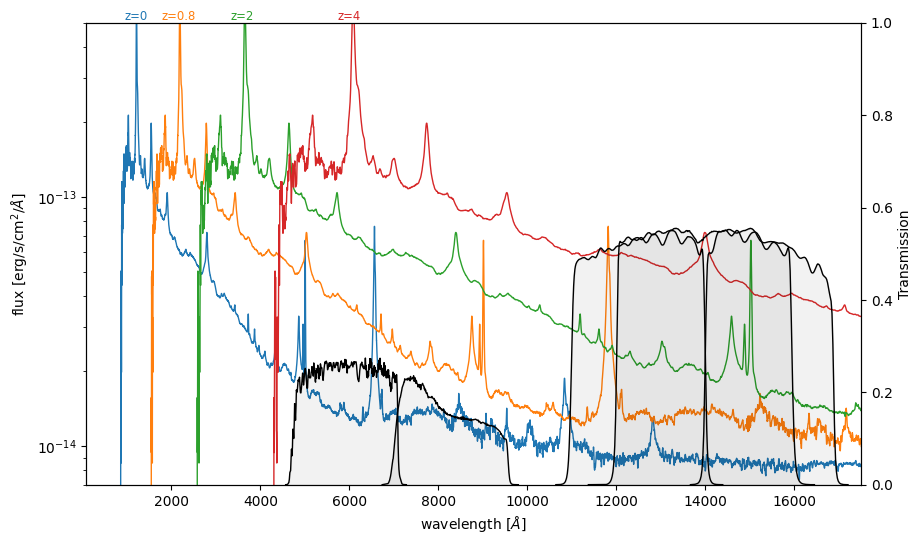

In [61]:
from io import BytesIO
import requests
from astropy.io import votable
from astropy.io import fits


def get_svo_filter_profile(identifier: str) -> np.array:
    QUERY_URL = "http://svo2.cab.inta-csic.es/theory/fps/fps.php"
    query = {"ID": identifier}
    response = requests.get(QUERY_URL, params=query)
    response.raise_for_status()
    table = votable.parse_single_table(BytesIO(response.content))
    tab = table.to_table()
    return (tab["Wavelength"].to("angstrom").value, tab["Transmission"].data)


template_url = "https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/comp_qso/optical_nir_qso_sed_001.fits"
with fits.open(template_url) as hdu:
    wave = hdu[1].data["WAVELENGTH"]
    flux = hdu[1].data["FLUX"]

plt.figure(figsize=(10, 6))

for z in (0, 0.8, 2, 4):
    line_color = plt.semilogy(wave * (1 + z), flux, lw=1)[0].get_color()
    plt.text(
        1_200 * (1 + z),
        5e-13,
        f"z={z}",
        ha="center",
        va="bottom",
        color=line_color,
        fontsize="small",
    )

plt.ylim(7e-15, 5e-13)
plt.xlim(86, 17_500)
plt.xlabel("wavelength [$\AA$]")
plt.ylabel("flux [erg/s/cm$^2$/$\AA$]")

ax = plt.twinx()
which_filters = [
    "HST/ACS_HRC.F606W",
    "HST/ACS_HRC.F814W",
    "HST/WFC3_IR.F125W",
    "HST/WFC3_IR.F140W",
    "HST/WFC3_IR.F160W",
]
for fname in which_filters:
    wave, trans = get_svo_filter_profile(fname)
    ax.plot(wave, trans, color="black", lw=1, label=fname)
    ax.fill_between(wave, trans, color="k", alpha=0.05)
    ax.set_ylim(0, 1)
    ax.grid(False)
ax.set_ylabel("Transmission")

Markdown("""
> **Figure**: Quasar template from [Glikman et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...640..579G/abstract), and passbands from [The SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/) ([Rodrigo, C., Solano, E., 2020](https://ui.adsabs.harvard.edu/abs/2020sea..confE.182R/abstract))
""")

### Data preparation

In [62]:
from astropy.utils.data import download_file
import tarfile
import os

if not (os.path.exists("3dhst_master.phot.v4.1.cat")):
    file_url = "https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar"
    tarfile.open(download_file(file_url, cache=True), "r:").extract(
        "3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat", "."
    )

In [63]:
import pandas as pd
fname = '3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat'
with open(fname, 'r') as fin:
    header = fin.readline()[1:]  #remove comment character
    df = pd.read_csv(fin, names=header.strip().split(), comment='#', delimiter='\s+')
df = df.set_index('id')

As we did in the previous session, we clean the data.

Here we will go further than last time. We will extract only the `f_*` columns as input features and the `zspec` column as the target. We will keep only positive fluxes, `star_flag = 0`. We could debate on the choice of the features, but we will keep it simple for now.

In [64]:
remove = [
    "field",
    "ra",
    "dec",
    "x",
    "y",
    "faper_F140W",
    "eaper_F140W",
    "faper_F160W",
    "eaper_F160W",
    "tot_cor",
    "kron_radius",
    "a_image",
    "b_image",
    "flux_radius",
    "fwhm_image",
    "flags",
    "f140w_flag",
    "star_flag",
    "use_phot",
    "near_star",
    "nexp_f125w",
    "nexp_f140w",
    "nexp_f160w",
    "lmass",
]

flux_cols = [name for name in df.columns if name.startswith("f_F")]
positive_flux = " & ".join([f"({col:s} > 0)" for col in flux_cols])
select_zphot = "(star_flag == 0) & (use_phot == 1) & (z_peak > 0) & (Av >= 0)"
select_zspec = "(star_flag == 0) & (z_spec > 0) & (Av >= 0)"

select = df.eval(select_zspec + '&' + positive_flux)
df = df[select].reset_index()
target = 'z_spec'
# features = [col for col in df_ if col not in remove + ['z_spec', 'z_peak'] ]
features = flux_cols  # + ['Av', 'near_star']


df_x = df[features]
df_y = df[target]

Markdown(f"""
The final data set
* contains **{len(df_x):,d} samples**
* **{len(df_x.columns):,d} features**
* **features** {features}
* **target**: {target} """)


The final data set
* contains **2,292 samples**
* **5 features**
* **features** ['f_F606W', 'f_F814W', 'f_F125W', 'f_F140W', 'f_F160W']
* **target**: z_spec 

Let's look at the "spectra"

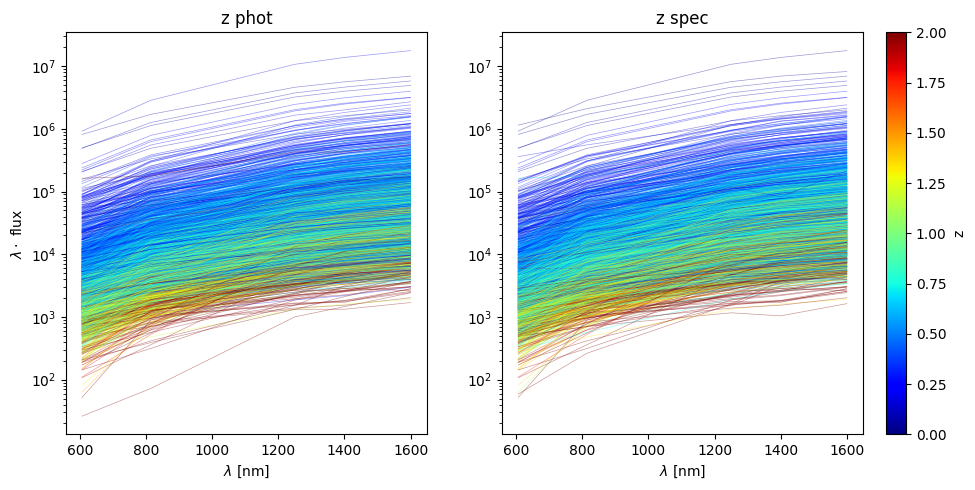

In [65]:
flux_cols = [name for name in df.columns if name.startswith('f_F')]
positive_flux = ' & '.join([f'({col:s} > 0)' for col in flux_cols])
x_ = np.array([606, 814, 1250, 1400, 1600])

select_zphot = '(star_flag == 0) & (use_phot == 1) & (z_peak > 0)'
select_zspec = '(star_flag == 0) & (z_spec > 0)'

cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=0, vmax=2)


plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
select = df.eval(select_zphot + '&' + positive_flux)
df_ = df[select]
ind = np.random.choice(len(df_), 2_000, replace=False)
X = df_[flux_cols].to_numpy()[ind]
y = df_['z_peak'].to_numpy()[ind]

for xk, yk in zip(X, y):
    color = cmap(norm(yk))
    plt.plot(x_, x_ * xk, color=color, rasterized=True, alpha=0.4, lw=0.5)

plt.yscale('log')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z phot')
cbar.ax.set_visible(False)
plt.ylabel('$\lambda  \cdot $ flux')
plt.xlabel('$\lambda$ [nm]')
plt.title('z phot')


plt.subplot(122,  sharex=ax, sharey=ax)
select = df.eval(select_zspec + '&' + positive_flux)
df_ = df[select]
ind = np.random.choice(len(df_), 2_000, replace=False)
X = df_[flux_cols].to_numpy()[ind]
y = df_['z_spec'].to_numpy()[ind]
for xk, yk in zip(X, y):
    color = cmap(norm(yk))
    plt.plot(x_, x_ * xk, color=color, rasterized=True, alpha=0.4, lw=0.5)
plt.yscale('log')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z')
plt.title('z spec')

plt.xlabel('$\lambda$ [nm]')

plt.tight_layout()

Finally, we can also convert the fluxes to log10(fluxes) to have a more normal distribution of the data.

In [66]:
df_x = pd.concat([df_[[fk for fk in features if fk not in flux_cols]],
                  np.log10(df_[flux_cols]).rename(columns={k: k.replace('f_', 'm_') for k in flux_cols})],
                  axis=1)
df_y = df_[target]

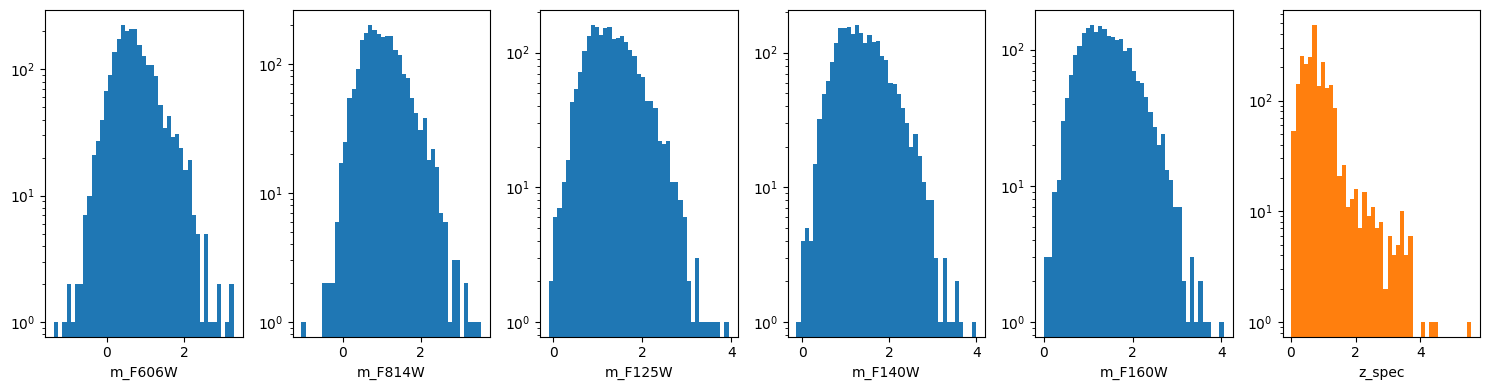

In [67]:
columns = [k for k in df_x.columns]

wrap = 6

nlines = (len(columns) + 1) // wrap +  int((len(columns) + 1) % wrap > 0)

plt.figure(figsize=(15, nlines * 4))
for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df_x[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.subplot(nlines, wrap, e + 1)
plt.hist(df_y, bins=43, log=True, color='C1')
plt.xlabel(target)

plt.tight_layout()

### Divide the data into train, test and validation sets

Divide the data into train, validation and test sets. We will use the following definitions:

* **Training**: The data used to update model parameters (e.g., coefficients or matrix element values).

* **Validation**: The data used to update model selection (for instance, we might change hyperparameters of a model based on the validation metrics).

* **Testing**: The data used to make final predictions, and possibly evaluate the final model score.

‚úçÔ∏è define the training, validation sets. (30% for validation, 70% for training)

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

### Model definition: single layer regression

‚úçÔ∏è define a DNNRegressor model with mutliple layers and activation functions.

In [69]:
class DNNRegressor(torch.nn.Module):
    def __init__(self, n_input: int, n_hidden: Sequence[int], n_output: int):
        super().__init__()
        self.sequence = nn.Sequential()
        self.sequence.add_module("input", nn.Linear(n_input, n_hidden[0]))
        for e, (n1, n2) in enumerate(zip(n_hidden[:-1], n_hidden[1:])):
            self.sequence.add_module(f"hidden_{e:d}", nn.Linear(n1, n2))
            self.sequence.add_module(f"hidden_activation_{e:d}", nn.ReLU())
        self.sequence.add_module("output", nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequence(x)

‚úçÔ∏è train the model, plot the learning curves. Be critical of the results. Maybe you need to tune the architecture, the optimizer, the learning rate, etc. Feel free to discuss with the group.

In [72]:
from sklearn.preprocessing import StandardScaler

model = DNNRegressor(len(features), [16] * 3, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 20_000

# preprocessing of the data
x_scaler = StandardScaler()
X_scaled = np.squeeze(x_scaler.fit_transform(X_train))
inputs = torch.from_numpy(X_scaled.astype('float32'))
targets = torch.from_numpy(y_train.to_numpy().astype('float32')).unsqueeze(1)
inputs_test = torch.from_numpy(x_scaler.transform(X_test).astype('float32'))
targets_test = torch.from_numpy(y_test.to_numpy().astype('float32')).unsqueeze(1)

#training loop
history = []
with tqdm(range(epochs), total=epochs) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_test = model(inputs_test)
        loss = criterion(outputs, targets)
        loss_test = criterion(outputs_test, targets_test)
        loss.backward()
        optimizer.step()
        history.append([epoch, loss.item(), loss_test.item()])
        pbar.set_postfix({"train loss": loss.item(), "test loss": loss_test.item()})

  0%|          | 0/20000 [00:00<?, ?it/s]

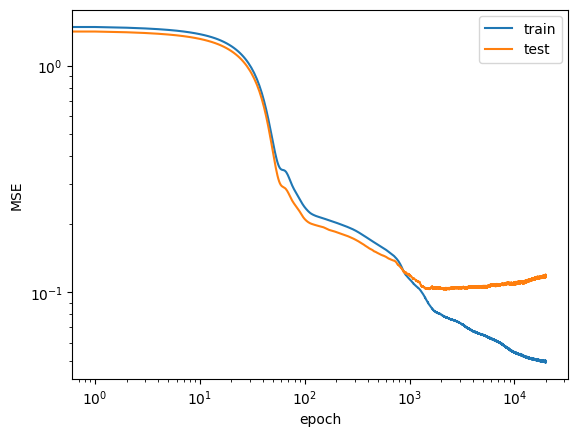

In [73]:
history = np.array(history)
plt.loglog(history[:, 0], history[:, 1], label='train')
plt.loglog(history[:, 0], history[:, 2], label='test')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()

‚úçÔ∏è Make some plots to understand what your model does

In [74]:
ypred_test = model(torch.from_numpy(x_scaler.transform(X_test).astype('float32'))).detach().numpy()
ypred_train = model(torch.from_numpy(X_scaled.astype('float32'))).detach().numpy()

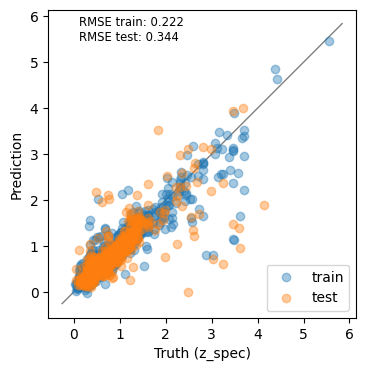

In [77]:
from sklearn.metrics import root_mean_squared_error as rmse
rmse_train = rmse(y_train, ypred_train)
rmse_test = rmse(y_test, ypred_test)

_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_train, ypred_train, label='train', rasterized=True, alpha=0.4)
ax.scatter(y_test, ypred_test, label='test', rasterized=True, alpha=0.4)
ax.plot(ax.get_xlim(), ax.get_xlim(), color='0.5', lw=1, zorder=-1)
ax.set_aspect('equal')
ax.set_xlabel('Truth (z_spec)')
ax.set_ylabel('Prediction')
plt.legend(loc='best')
ax.text(0.1, 0.9, f"RMSE train: {rmse_train:.3f}\nRMSE test: {rmse_test:.3f}",
        transform=ax.transAxes, fontsize='small');

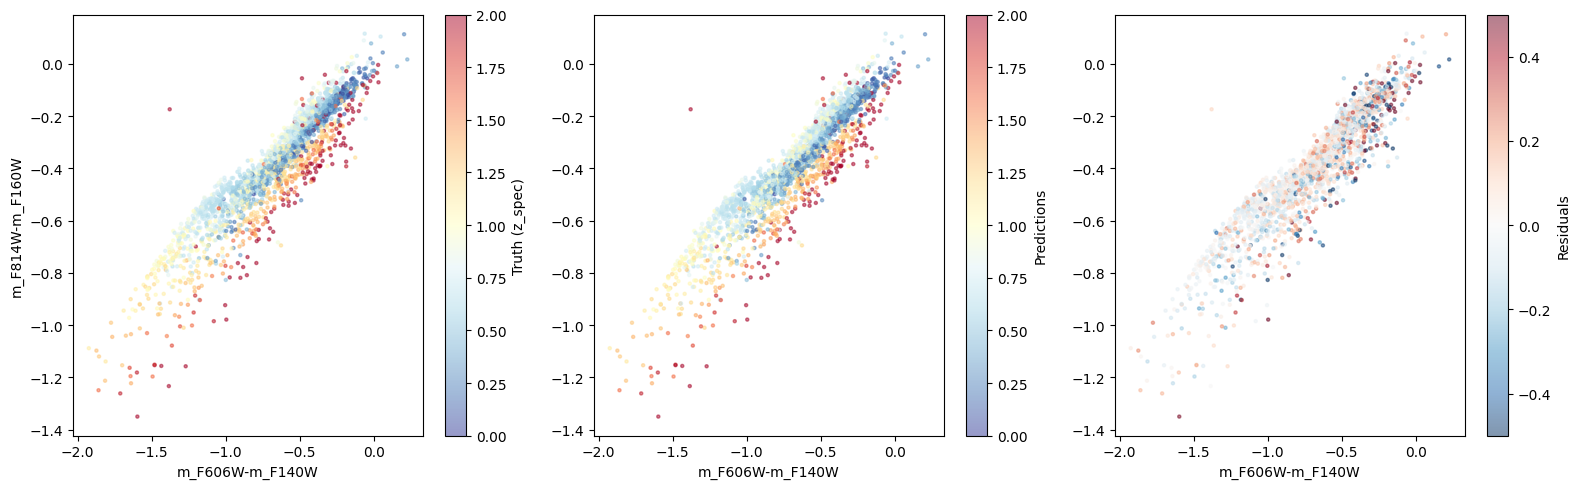

In [83]:
xq = "m_F606W-m_F140W"
yq = "m_F814W-m_F160W"

_, axes = plt.subplots(1, 3, figsize=(16, 5))

# Catalog
sc = axes[0].scatter(df_x.eval(xq), df_x.eval(yq), c=df_y, cmap='RdYlBu_r', s=5, alpha=0.5, vmin=0, vmax=2)
plt.colorbar(sc, ax=axes[0]).set_label('Truth (z_spec)')
axes[0].set_xlabel(xq)
axes[0].set_ylabel(yq)

# Train & test
df_x_ = df_x.loc[X_train.index]
df_y_ = df_y.loc[X_train.index]
sc = axes[1].scatter(df_x_.eval(xq), df_x_.eval(yq), c=df_y_, cmap='RdYlBu_r', s=5, alpha=0.5, vmin=0, vmax=2)
df_x_ = df_x.loc[X_test.index]
df_y_ = df_y.loc[X_test.index]
axes[1].scatter(df_x_.eval(xq), df_x_.eval(yq), c=df_y_, cmap='RdYlBu_r', s=5, alpha=0.5, vmin=0, vmax=2)
plt.colorbar(sc, ax=axes[1]).set_label('Predictions')
axes[1].set_xlabel(xq)

# residuals
df_x_ = df_x.loc[X_train.index]
df_y_ = df_y.loc[X_train.index]
sc = axes[2].scatter(df_x_.eval(xq), df_x_.eval(yq), c=df_y_ - ypred_train.squeeze(), cmap='RdBu_r', s=5, alpha=0.5, vmin=-0.5, vmax=0.5)
df_x_ = df_x.loc[X_test.index]
df_y_ = df_y.loc[X_test.index]
axes[2].scatter(df_x_.eval(xq), df_x_.eval(yq), c=df_y_ - ypred_test.squeeze(), cmap='RdBu_r', s=5, alpha=0.5, vmin=-0.5, vmax=0.5)
plt.colorbar(sc, ax=axes[2]).set_label('Residuals')
axes[2].set_xlabel(xq)

plt.tight_layout()

As before, we will use the SHAP values to understand the model's behavior.

In [84]:
import shap
torch.set_grad_enabled(True)
# explain the model's predictions using SHAP
explainer = shap.DeepExplainer(model, inputs)
shap_values = explainer.shap_values(inputs)

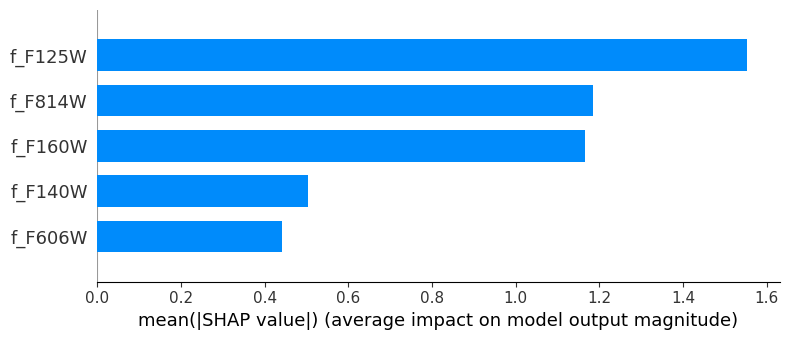

In [85]:
shap.summary_plot(shap_values.squeeze(),
                  inputs.numpy(),
                  np.array(features),
                  plot_type='bar')

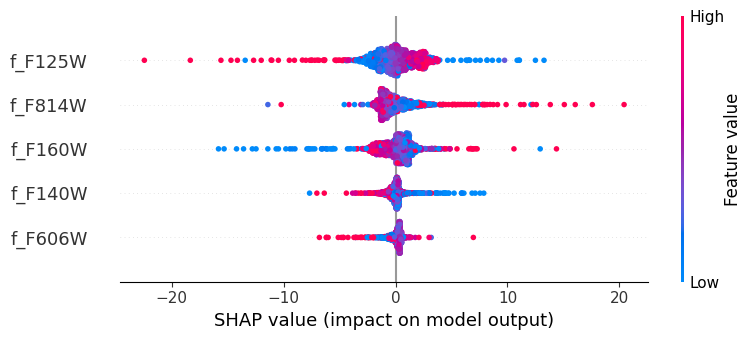

In [86]:
shap.summary_plot(shap_values.squeeze(),
                  inputs.numpy(),
                  np.array(features))

The results are not as good as the tree based methods we explored last week. 
What can we do to improve the model?